## Run throught some Clustering Approaches on the Chicago Crime Data:
----------

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import itertools
from copy import deepcopy
import numpy as np
import pandas as pd

# Spatial Libraries
import utm
import shapely as shp
import geopandas as gpd
from shapely.geometry import Point

# Clustering Libraries
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Plotting Libraries
import plotly
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import plotly.graph_objs as go
# plotly.offline.init_notebook_mode() 
plotly.offline.init_notebook_mode(connected=True)

import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline
plotly.__version__

'2.0.8'

In [2]:
class SpatialHandler():
    
    def __init__(self):
        pass
    
    def set_data(self, dataIN):
        self.dataIN = dataIN
          
    def latlon_toUTM(self, lat, long):
        '''
            Input: Latitude and Longitude
            Output: Longitude and Latitude UTM projections 
        '''
        tup = utm.from_latlon(lat,long)
        lat_cnvrt = tup[0]
        long_cnvrt = tup[1]

        return long_cnvrt, lat_cnvrt
    
    def transform_toUTM(self, column_Lat, column_Lon, **kwargs):
        utmProj = []
        geomPoints_UTM = []
        geomPoints_LatLon = []
        
        kwargsKeys = kwargs.keys()
        for lat, lon in zip(self.dataIN[column_Lat], self.dataIN[column_Lon]):
            if 'to_UTM' in kwargsKeys:
                columnOut_1 = self.latlon_toUTM(lat, lon)
                utmProj.append(columnOut_1) 
                
            if 'to_GeoPoints' in kwargsKeys and 'UTM' in kwargs['to_GeoPoints']:
                try:
                    geomPoints_UTM.append(Point(columnOut_1))   
                except UnboundLocalError:
                    raise UnboundLocalError('You should first transform the data into UTM !!')
                    
            
            if 'to_GeoPoints' in kwargsKeys and 'LatLon' in kwargs['to_GeoPoints']:
                geomPoints_LatLon.append(Point(lat,lon))
                
                
        return (np.array(utmProj, dtype='float64'), 
                gpd.GeoSeries(geomPoints_UTM), 
                gpd.GeoSeries(geomPoints_LatLon))
    
    
    def transform_toMerc(self, column_LatLon, dataIN=[], epsg=3395):
        if any(dataIN):
            self.dataIN = dataIN
            
        self.dataIN = self.dataIN.set_geometry(column_LatLon)
        
        LatLon = self.dataIN[column_LatLon]
        LatLon.crs = {'init': 'epsg:4326'}       ## Initialize the current column as espg:4326 for further conversion
        epsgStr = 'epsg:'+str(epsg)
        geomPoints_Merc = LatLon.to_crs({'init': epsgStr})  ## Create a new GeoSeries with Mercector projection
        
        return geomPoints_Merc


In [3]:
class GlobalPlot(object):
    def __init__(self):
        pass
        
    def get_Plot_info(self):
        plotInfo = dict(
            plot_type = 'scatter, histogram2Dcontours',
            plot_mode = "lines, markers, lines+markers, lines+markers+text",
            marker_conf = dict(
                size = '3 to 10',
                opacity = '0.3 to 0.7',
                color = 'black, white , etc. When using group on a third column then pass in the column values;',
                colorscale ='Viridis etc. Use when performing a group by on a third column values. Optimal when many values in 3rd column',
                showscale = 'True or False : Should you choose to activate the color scale or not'
            )
        ) 
        
        return plotInfo
        
    def get_GeoPlot_info(self):
        pass
    
    def set_figure(self):
        pass
    
    def base_plot(self):
        pass
    
    def add_plot(self):
        pass

In [4]:
class GeoPlot():
    def __init__(self):
        GlobalPlot.__init__(self)
        self.newPlot = None
        self.basePlot = None
        self.axPointer = None
        
        # We basically make a default subplot, However this can be overridden by calling
        # the set_figure function
        self.fig, self.ax = plt.subplots(1,1, 
                                         figsize=(10, 10), 
                                         facecolor='w', edgecolor='k')
        
    def set_figure(self, numRows=1, numColumns=1, lenXaxis=40, lenYaxis=15):
        self.fig, self.ax = plt.subplots(numRows, 
                                         numColumns, 
                                         figsize=(lenXaxis, lenYaxis), 
                                         facecolor='w', edgecolor='k')
        if numRows>1 or numColumns>1:
            self.ax = self.ax.ravel()
            self.axPointer = 0
            
            
    def set_data(self, dataIN):
        self.dataIN = dataIN
        
    def base_plot(self, color='white', dataIN=[]):
        if any(dataIN):
            self.dataIN = dataIN
            
        if self.axPointer != None:
            self.basePlot = self.dataIN.plot(ax=self.ax[self.axPointer], color=color)
            self.axPointer += 1
        else:
            self.basePlot = self.dataIN.plot(ax=self.ax, color=color)
            
    def add_plot(self, dataIN):
        if self.newPlot == None:
            self.newPlot = dataIN.plot(ax=self.basePlot, marker='o', color='red', markersize=7)
        else:
            self.newPlot = dataIN.plot(ax=self.newPlot, marker='o', color='red', markersize=7)       

In [116]:
class Plot(GlobalPlot):
    def __init__(self):
        GlobalPlot.__init__(self)
        self.fig = tools.make_subplots(rows=1, cols=1)
        self.fig['layout'].update(height=400, width=400)
        
        # Plot Layout/config default
        self.plot_type = 'scatter'
        self.plot_mode = 'lines+markers'
        self.plot_name = 'noName_given'
        self.marker_config=dict(
                        size='6',
                        opacity=0.3,
                        color = 'black',
                    )
        
    def plot_config(self, conf=None):
        if conf:
            confKeys = conf.keys()
        else:
            confKeys = []
            
        if 'plot_type' in confKeys:
            self.plot_type = conf['plot_type']
            
        if 'plot_mode' in confKeys:
            self.plot_mode = conf['plot_mode']            
            
        if 'plot_name' in confKeys:
            self.plot_name = conf['plot_name'] 
        
        if 'marker_config' in confKeys:
            self.marker_config = conf['marker_config']
            
            
    def get_plot(self):
        if self.plot_type=='scatter':
            if self.plot_mode == 'markers':
                trace = go.Scatter(
                        x=self.x,
                        y=self.y,
                        name = self.plot_name,
                        mode=self.plot_mode,
                        marker=self.marker_config#Marker(color='black', size=3, opacity=0.2)
                    )
            else:
                trace = go.Scatter(
                        x=self.x,
                        y=self.y,
                        name = self.plot_name,
                        mode=self.plot_mode
                    )
                
        elif self.plot_type=='hist2Dcontour':
            trace = go.Histogram2dcontour(
                        x=self.x,
                        y=self.y,
                        name = self.plot_name,
                        ncontours=20,
                        colorscale='Hot',
                        reversescale=True, 
                        showscale=False
                    )
        else:
            raise Exception('You should specify at one type of plot')
            
        return trace
        
        
    def set_figure(self, numRows, numColumns, height=None, width=None, title=None):
        self.numRows = numRows
        self.numColumns = numColumns
        if height:
            height = height
        else:
            height = numRows*400
            
        if width:
            width = width
        else:
            width = numColumns*400
        
        
        self.fig = tools.make_subplots(rows=numRows, cols=numColumns)
        if title:
            self.fig['layout'].update(height=height, width=width, title=title)
        else:
            self.fig['layout'].update(height=height, width=width)
        
        self.subplotList = list(itertools.product(np.arange(numRows)+1, np.arange(numColumns)+1))
        self.subplotIndex = 0
        
    def set_data(self, x,y):
        self.x = x
        self.y = y
        
    def base_plot(self, x=False, y=False):#dataIN=False):
        '''  
            Give as input a DataFrame with two columns as input
            Where the 1st column is to be plotted in the X axis
            and the 2nd column is to be plotted in y axis
        '''
        (self.rowIndex,  self.columnIndex) = self.subplotList[self.subplotIndex]
        
        if any(x):
            self.x = x
        if any(y):
            self.y = y

        trace = self.get_plot()
        self.fig.append_trace(trace, self.rowIndex, self.columnIndex)
        self.subplotIndex += 1
        
    def add_plot(self, x=False, y=False):   
        # When we add_plot we actually overlay the new plot on top of the provious plot.
        # Since we increase the base_plot every time. We decrease it by 1 here so that we
        # can overlay the new plot on the base plot
        self.subplotIndex -= 1
        (self.rowIndex,  self.columnIndex) = self.subplotList[self.subplotIndex]
        
        if any(x):
            self.x = x
        if any(y):
            self.y = y
            
        trace = self.get_plot()
        self.fig.append_trace(trace, self.rowIndex, self.columnIndex)
        self.subplotIndex += 1
        
    def show(self):
        iplot(self.fig)

In [90]:
chicago_crm_pointsDir = '/Users/sam/All-Program/App-DataSet/Study/GeoSpatial-Analysis/Crimes2015_NA_rmv_sampl.csv'
chicagoCrime = pd.read_csv(chicago_crm_pointsDir)

# Renaming Dataset:
chicagoCrime = chicagoCrime[['Latitude', 'Longitude']]
chicagoCrime.head()

# Spatial Handler
objSpHandler = SpatialHandler()
objSpHandler.set_data(chicagoCrime)
kwargs = {'to_UTM':True, 'to_GeoPoints':['UTM', 'LatLon']}
(utmProj, geomPoints_UTM, geomPoints_LatLon) =  objSpHandler.transform_toUTM('Latitude', 'Longitude', **kwargs)

# Now we add the columns to the DataFrame
chicagoCrime['latUTM'] = utmProj[:,0]
chicagoCrime['lonUTM'] = utmProj[:,1]
chicagoCrime['geometryUTM'] = geomPoints_UTM
chicagoCrime['geometryLatLan'] = geomPoints_LatLon


# We would also like to add a colum with a different Mercetor projection
objSpHandler.set_data(chicagoCrime)
geomPointsMerc = objSpHandler.transform_toMerc('geometryLatLan', epsg=3857)
chicagoCrime['geometryMerc'] = geomPointsMerc
chicagoCrime.head()


,Latitude,Longitude,latUTM,lonUTM,geometryUTM,geometryLatLan,geometryMerc
0,41.998718,-87.680163,4.649858e+06,443669.248394,POINT (4649857.621612935 443669.2483944244),POINT (41.998718085 -87.680162979),POINT (4675275.911192449 -24873079.72849208)
1,41.934630,-87.746718,4.642788e+06,438095.172660,POINT (4642787.870839979 438095.1726599361),POINT (41.934629749 -87.746717696),POINT (4668141.630263143 -25058790.07014762)
2,41.923673,-87.786302,4.641601e+06,434802.385543,POINT (4641600.656321065 434802.3855430915),POINT (41.923672617 -87.78630160600001),POINT (4666921.887908347 -25171860.70101135)
3,41.965391,-87.658037,4.646143e+06,445473.280365,POINT (4646142.993461905 445473.2803646126),POINT (41.965390764 -87.658037135),POINT (4671565.930789226 -24812518.71715309)
4,41.884014,-87.730674,4.637157e+06,439377.384825,POINT (4637156.675222915 439377.3848248574),POINT (41.884014312 -87.73067384399999),POINT (4662507.145590023 -25013525.5344593)


### Plots to Vizualize the Data:
-----------

#### Using Plotly:

In [113]:
obj_plot = Plot()
obj_plot.set_figure(1,2, 600,1200)

# plot1
obj_plot.plot_config({'plot_type':'scatter', 'plot_mode':'markers', 'plot_name':'scatter_LatLon'})
obj_plot.base_plot(x=chicagoCrime['latUTM'], y=chicagoCrime['lonUTM'])


# plot2
obj_plot.plot_config({'plot_type':'scatter', 'plot_mode':'markers', 'plot_name':'histogram Contours 2D'})
obj_plot.base_plot(x=chicagoCrime['latUTM'], y=chicagoCrime['lonUTM'])
obj_plot.plot_config({'plot_type':'hist2Dcontour'})
obj_plot.add_plot(x=chicagoCrime['latUTM'], y=chicagoCrime['lonUTM'])

obj_plot.show()

This is the format of your plot grid:
[ (1,1) x1,y1 ]

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



#### Using GeoPlot:

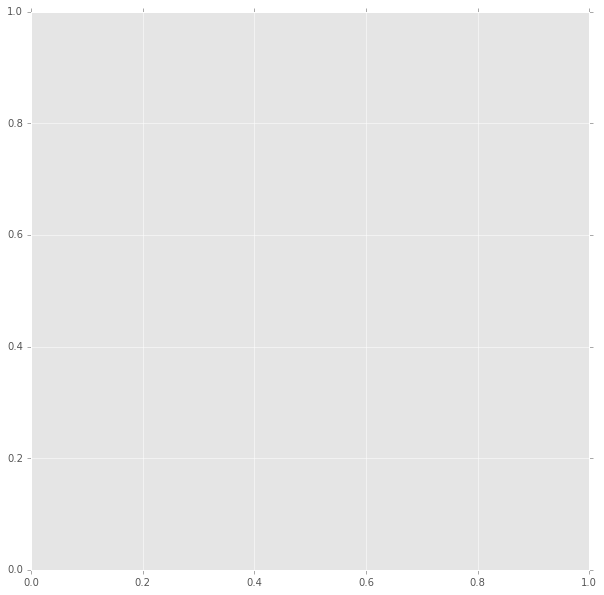

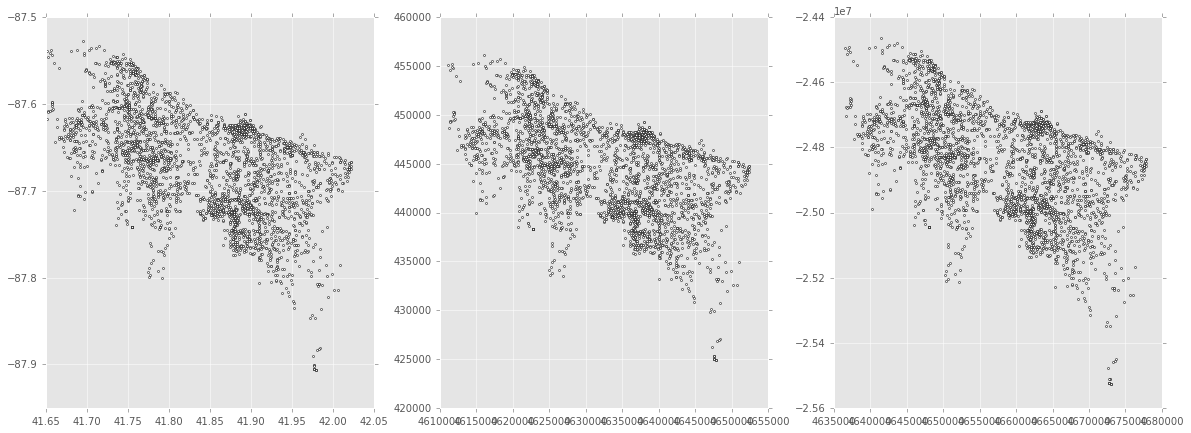

In [7]:
# Figure Frame
obj_plot = GeoPlot()
obj_plot.set_figure(1,3,20,7)

# Plot 1
# We make one of the column as the geometry column
chicagoCrime = chicagoCrime.set_geometry('geometryLatLan')
obj_plot.set_data(chicagoCrime)
obj_plot.base_plot()


# Plot 2
# We make one of the column as the geometry column
chicagoCrime = chicagoCrime.set_geometry('geometryUTM')
obj_plot.set_data(chicagoCrime)
obj_plot.base_plot()


# Plot 2
# We make one of the column as the geometry column
chicagoCrime = chicagoCrime.set_geometry('geometryMerc')
obj_plot.set_data(chicagoCrime)
obj_plot.base_plot()

#### Circle Plots with a buffer Radius:

In [31]:
circles = chicagoCrime['geometryUTM'].buffer(300)   # Buffer is some what like how 
Plot().base_plot(dataIN=circles)

### Clustering Approaches:
-----------

**Nearest Neighbor**

***Sample Size and numeber of dimensions***:

* The Choice of datastructure for Nearest neighbor could play some role:
   * Brute Force: O(nD) where N is the sample size and D is the dimensionality.
   * KD Tree:  Good for many cases but doesn't perform much better with high dimension (When D is extremly large).
      * O(DlogN) -> when D is small say 20 dimensions
      * O(DN) -> when D is large
   * Ball Tree: Complexity increases with n and D but is proven to be better than KD trees even at higher D.
      * O(DlogN) -> Complexity increases with this proportion
      
In our case we have only 2 Dimension, but very large N, so brute force is not a good solution, Either of KD Tree or Ball Tree should do good.
However KD trees are more efficient (time wise) with low dimension data Set.

***Number of Neighbor: (k)***:
Brute force: The number of k doesnt affect brute force because we anyway visit all the datapoints O(N) for a query.
KD Tree and Ball Tree: The bigger the k the more the complexity (search query time) as we have to visit/search a larger parameter space.

***Number of Leaves (leaf_size)*** (Only for tree data structure)
The more the leaf size the faster the tree construction, since we dont have to go many-many levels.
When leaf_size=1 then we have a tree with a depth of log(N) which results in overhead while tranversing the tree that results in slow query time. When leaf_size=N then we get a brute force problem, which means the depth of the tree is 1 but we still have to visit each datapoints in worst case.

***Note:***
* Approximate Nearest Neighbor (LSHForest)-Local sensitivity hashing: This approach 

In [83]:
class Operations():
    def __init__(self):
        pass
    
    def get_sparseNeighbors(self, dataIN, radius=500):
        '''
            input: A matrix/dataFrame (only numerical attributes)
            output: A Sparse matrix with cell value equal to 1 corresponsing to all nearest neighbors
            Function: Finds all the points (nearest neighbors) within a certain radius from each data point
        '''
        neigh = NearestNeighbors(radius=radius)
        neigh.fit(dataIN) 
        sparseNeighbors = neigh.radius_neighbors_graph(dataIN)
        return sparseNeighbors #sparseNeighbors.toarray()
    
    def standarize(self, dataIN):
        return (dataIN-np.mean(dataIN, axis=0))/np.std(dataIN, axis=0)

class DBSCAN_Cluters():
    def __init__(self, eps=0.5,             # Maximum distance between two datapoints
                 min_samples=5,             # number of minimum neighbors around the point to be considered as a core point
                 metric='euclidean',        # The distance metric to be used   
                 algorithm='auto',          # The datastructure to be used while making search example: ‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’
                 leaf_size=30,              # Number of leaves node
                 p=None,                    # The power of miskowski metric 1 for L1(norm), 2 for L2(euclidean norm)
                 n_jobs=1):                 # If -1 then the number of jobs are considered equal to the number of CPU cores
        '''
             eps -> Maximum distance between two points to be considered in the same neighborhood
             min_samples -> The number of samples in a neighborhood for a point to be considered as a core point.
        '''
        
        self.dbscan = DBSCAN(eps=eps, min_samples=min_samples, 
                             metric=metric, algorithm=algorithm, 
                             leaf_size=leaf_size, p=p,
                             n_jobs=n_jobs)
    
    def set_data(self, dataIN):
        self.dataIN = dataIN

    def fit(self):
        fitObj = self.dbscan.fit(deepcopy(self.dataIN))
        
    def fit_predict(self):
        '''
            Fits the DBSCAN model and transforms the data 
            (For unsupervised algorithm we apply the predict on the data)
        '''
        clusterLabels = self.dbscan.fit_predict(deepcopy(self.dataIN))
        return clusterLabels
    
    def cluster_info(self, clusterLabels):
        clst = pd.DataFrame({'clusterNo':clusterLabels, 'count':np.ones(len(clusterLabels), dtype=int)})
        groupByDF = (clst.groupby('clusterNo')
           .agg({'count':'sum'})
           .sort_values('count', ascending=False)
           .reset_index())
        return groupByDF
    
#     def get_topcluster
    
    # Now we fit the data and cluster the data.


In [127]:
# # Take a new copy of the chicagiCrime Data
# chicagoCrimeNew = 

# Prepare DataSet

dataIN = np.array(chicagoCrime[['latUTM','lonUTM']])#[[0,0], [2,0], [0,2]]#[[0., 0., 0.], [0., .5, 0.], [1., 1., .5]]
dataIN = Operations().standarize(dataIN)#(dataIN-np.mean(dataIN, axis=0))/np.std(dataIN, axis=0)
print ('The shape of input data is: ', dataIN.shape)

# Calculating sparse neighbors, This preprocessing would help us to reduce 1 on 1 compare later with the density algorithm
# sparseNeighbors = Operations().get_sparseNeighbors(dataIN)

# # We would like to print the number of neighbors for some random samples
# randNUM = np.random.randint(0,300,50)
# print (np.sum(sparseNeighbors[randNUM].toarray(), axis=1))

## Clustering:
onjDBSCAN = DBSCAN_Cluters(eps=0.1, min_samples=19, metric='euclidean')
onjDBSCAN.set_data(dataIN)
clusterLabels = onjDBSCAN.fit_predict()
clusters = np.unique(clusterLabels)
print ('The shape of cluster labels: ', clusterLabels.shape)
print ('Clusters are: ', np.unique(clusters))


## Add the cluster column to the dataframe:
chicagoCrimeNew = chicagoCrime
chicagoCrimeNew['clusterNo'] = clusterLabels


## Analysis:
cluster_groupByDF = onjDBSCAN.cluster_info(clusterLabels)
print (cluster_groupByDF.head())

## Plots:
obj_plot = Plot()
obj_plot.set_figure(1,2, 600,1200)

# Plot 1
obj_plot.plot_config(dict(plot_type='scatter', plot_mode='markers', plot_name='scatter LatLon'))
obj_plot.base_plot(x=dataIN[:,0], y=dataIN[:,1])
# Plot 2
obj_plot.plot_config(dict(plot_type='scatter', plot_mode='markers', marker_config=dict(color=clusterLabels, colorscale='Viridis', showscale=True, size=6, opacity=0.6)))
obj_plot.base_plot(x=dataIN[:,0], y=dataIN[:,1])
obj_plot.show()

The shape of input data is:  (3000, 2)
The shape of cluster labels:  (3000,)
Clusters are:  [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
   clusterNo  count
0         -1   1600
1          1    435
2          2    243
3          6    115
4          5     98
This is the format of your plot grid:
[ (1,1) x1,y1 ]

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [128]:
clusterLabels

array([-1, -1, -1, ...,  3, -1, -1])

# Rough:
--------------

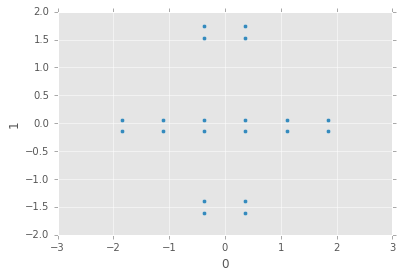

In [72]:
# Simulated DataSet
X = np.array([[1,8],[1,9],
              [2,8],[2,9],
              [3,8],[3,9],
              [4,8],[4,9],
              [5,8],[5,9],
              [6,8],[6,9],
              [3,1],[3,2],
              [4,1],[4,2],
              [3,16],[3,17],
              [4,16],[4,17]])
# Preprocess
Xt = (X-np.mean(X, axis=0))/np.std(X, axis=0)
X_DF = pd.DataFrame(Xt)
X_DF.plot.scatter(x=0, y=1)

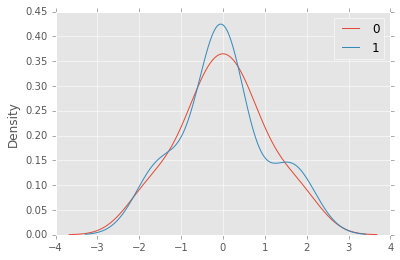

In [73]:
X_DF.plot.density()

In [36]:
X.shape

neigh = NearestNeighbors(radius=2)
neigh.fit(X) 
A = neigh.radius_neighbors_graph(X)
A.toarray()

# We would like to print the number of neighbors for some random samples
# randNUM = np.random.randint(0,300,50)
print (np.sum(A.toarray(), axis=1))

[ 5.  5.  7.  7.  8.  8.  8.  8.  7.  7.  5.  5.  4.  4.  4.  4.  4.  4.
  4.  4.]


In [62]:
print (np.mean(X, axis=0))
print (np.std(X, axis=0))

print (X)
print ((X-np.mean(X, axis=0))/np.std(X, axis=0))

[ 3.5  8.7]
[ 1.36014705  4.77598157]
[[ 1  8]
 [ 1  9]
 [ 2  8]
 [ 2  9]
 [ 3  8]
 [ 3  9]
 [ 4  8]
 [ 4  9]
 [ 5  8]
 [ 5  9]
 [ 6  8]
 [ 6  9]
 [ 3  1]
 [ 3  2]
 [ 4  1]
 [ 4  2]
 [ 3 16]
 [ 3 17]
 [ 4 16]
 [ 4 17]]
[[-1.83803656 -0.14656673]
 [-1.83803656  0.06281431]
 [-1.10282193 -0.14656673]
 [-1.10282193  0.06281431]
 [-0.36760731 -0.14656673]
 [-0.36760731  0.06281431]
 [ 0.36760731 -0.14656673]
 [ 0.36760731  0.06281431]
 [ 1.10282193 -0.14656673]
 [ 1.10282193  0.06281431]
 [ 1.83803656 -0.14656673]
 [ 1.83803656  0.06281431]
 [-0.36760731 -1.61223403]
 [-0.36760731 -1.40285298]
 [ 0.36760731 -1.61223403]
 [ 0.36760731 -1.40285298]
 [-0.36760731  1.52848161]
 [-0.36760731  1.73786265]
 [ 0.36760731  1.52848161]
 [ 0.36760731  1.73786265]]


In [65]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=1, min_samples=2, metric="precomputed")
# eps -> Maximum distance between two points to be considered in the samae neighborhood
# min_samples -> The number of samples in a neighborhood for a point to be considered as a core point.

# Now we fit the data.
labels = dbscan.fit_predict(Xt)
print ([i for i in labels])
print (len(labels))

# Observation:
# We see that first 12 elements belongs to the cluster 0, next 4 belongs to a cluster 1 and the last 4 belongs to cluster 2. This makes compete sense 
# As we pusposely build the dataset keeping these three clusters and DBSCAN was able to find it.

In [74]:
onjDBSCAN = DBSCAN_Cluters(eps=0.75, min_samples=2, metric='euclidean')
onjDBSCAN.set_data(X_DF)
clusterLabels = onjDBSCAN.fit_predict()
clusters = np.unique(clusterLabels)
print ('Clusters are: ', np.unique(clusters))


# Add the cluster column to the dataframe:
X_DF['clusterNo'] = clusterLabels


# Analysis:
cluster_groupByDF = onjDBSCAN.cluster_info(clusterLabels)
cluster_groupByDF.head()

Clusters are:  [0 1 2]


,clusterNo,count
0,0,12
1,1,4
2,2,4


In [75]:
trace1 = go.Scatter(
    x = X_DF.iloc[:,0],
    y = X_DF.iloc[:,1],
    mode='markers',
    marker=dict(
        size='6',
        color = X_DF.iloc[:,2], #set color equal to a variable
        colorscale='Viridis',
        showscale=True
    )
)
data = [trace1]

iplot(data)

In [44]:
X_DF.iloc[:,2]

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    1
13    1
14    1
15    1
16    2
17    2
18    2
19    2
Name: clusterNo, dtype: int64